# Lab 4

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy.signal
import matplotlib.cm as cm
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle
from astropy.io import fits
import os

In [3]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

In [4]:
def calc_avg_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.mean(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_avg(data):
    return np.mean(data, axis=1)

def calc_median_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.median(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_freq(samples, frequency):
    return np.fft.fftshift(np.fft.fftfreq(samples, d=1/frequency))

In [114]:
# (l = 105◦ to 160◦),(b = 15◦ to 50◦)

dg = u"\N{DEGREE SIGN}"

def plot_FOV(ax, color, label):
    
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    n = 10
    xarr = np.arange(105, 160, 2)
    yarr = np.arange(15, 50, 2)
    for i in range(len(xarr)):
        for j in range(len(yarr)):
            x, y = xarr[i], yarr[j]
            gal = SkyCoord(x*u.degree, y*u.degree, frame='galactic')
            ra_dec = gal.transform_to('fk5')
#             print(ra_dec)
        #     gal = eq.galactic
        #     print(gal.l)

        #     ax.scatter(gal.l,gal.b,alpha=0.5,marker="s",s=200,color=color, label=label)
            ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                         edgecolor = color,
                         facecolor = color,
                         alpha=0.5,
                         fill=True,
                         lw=3))
    
# plot_FOV(ax, RA_z, DEC_z, color="blue", label="Calibration")

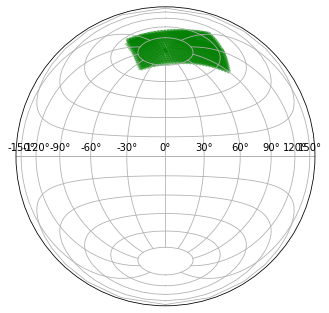

In [115]:
f = plt.figure(figsize=(9,5.5))

ax = plt.subplot(111, projection='lambert')
ax.grid(True)

plot_FOV(ax, color="green", label="Target")

In [5]:
import matplotlib
matplotlib.projections.get_projection_names()

['aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear']

In [133]:
# fits_image_filename = fits.util.get_testdata_filepath('data/off.fits')

off_data = fits.open('data/off.fits')
on_data = fits.open('data/on.fits')

In [122]:
off_data[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                  100 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

In [147]:
data_off = np.zeros((8192, len(off_data)-1))
data_on = np.zeros((8192, len(off_data)-1))
# print(off_data.shape)
for i in range(1, len(off_data)):
    data_off[:,i-1] = off_data[i].data['auto0_real']
    data_on[:,i-1] = on_data[i].data['auto0_real']

In [150]:
print(data_on.shape)
print(data_on)

(8192, 100)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00893892 0.00844022 0.00881813 ... 0.00884921 0.00875845 0.00841755]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


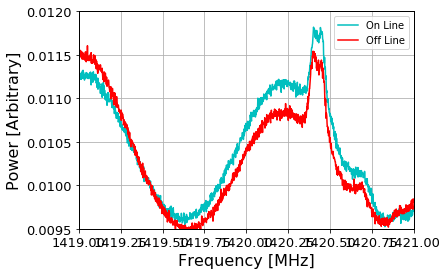

In [177]:
avg_fft_off = calc_avg_power_fft(data_off)
avg_fft_on = calc_avg_power_fft(data_on)
freq = calc_freq(samples=8192, frequency=150)
freq = np.linspace(144, 156, 8192)
# plt.plot(freq+1270, avg_fft_off, label='Off')
# plt.plot(freq+1270.8, avg_fft_on, label='On')
avg_data_on = calc_avg(data_on)
avg_data_off = calc_avg(data_off)
plt.plot(freq+1270, avg_data_on, label='On Line', color='c')
plt.plot(freq+1270.8, avg_data_off, label='Off Line', color='r')
plt.ylim(0.0095, 0.012)
plt.xlim(1419, 1421)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [Arbitrary]')
plt.legend()
# plt.xlim(1420,1421)

## Process coordinate data from Darby's folder

In [8]:
# SCRIPT TO COMPRESS TO NUMPY ARRAYS
import os
from astropy.io import fits

# data_dict = {} # dict where key is coordinate [l, b] and value is [main, noise_on, noise_off]
for filename in os.listdir(os.getcwd()):
    if filename == ".ipynb_checkpoints":
        continue
    split_name = filename.split("_")
    if split_name[0] != 'celestial':
        continue

    if split_name[2] == 'off':
        prefix = 'off' # off
    elif splits_name[2] == 'on':
        prefix = 'on' # on
    else:
        prefix = 'main' # main

    l, b = split_name[-1].split(" , ")
    b = b.split('.fits')[0]
    num_l, num_b = float(l), float(b) # convert strings to floats

#         if not data_dict.get([l, b]):
#             data_dict[[l, b]] = [[], [], []]
#         data_dict[[l, b]][fits_type] = curr_data
    fits_data = fits.open(filename)
    data_arr = np.zeros((8192, len(fits_data)-1))

    for i in range(1, len(fits_data)):
        data_arr[:,i-1] = fits_data[i].data['auto0_real']
    
    new_filename = os.getcwd() +'/celestial_data/' + prefix + '_' + l + '_' + b + '_.fits'
    np.save(data_arr, new_filename)
    
        

In [17]:
# CODE TO LOAD SPECTRA NUMPY FILES IN A DICT

data_dict = {} # dict where key is coordinate (l, b)) and value is [main, noise_on, noise_off]
                # where main, noise_on, noise_off are all numpy arrays of the spectra
for filename in os.listdir(os.getcwd() + '/celestial_data'):
    if filename == ".ipynb_checkpoints":
        continue
    split_name = filename.split("_")

    if split_name[0] == 'off':
        fits_type = 2 # off
    elif split_name[0] == 'on':
        fits_type = 1 # on
    else:
        fits_type = 0 # main

    l, b = split_name[1], split_name[2]
    l, b = float(l), float(b) # convert strings to floats

    curr_data = np.load('celestial_data/' + filename) # load the spectra from file
    curr_data = calc_avg(curr_data)
    
    if not data_dict.get((l, b)):
        data_dict[(l, b)] = [[], [], []]
    data_dict[(l, b)][fits_type] = curr_data
        

In [18]:
for coord in data_dict.keys():
    l, b = coord
    main, noise_on, noise_off = data_dict.get(coord)
    # process data